In [1]:
import tensorflow as tf
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras import layers
#from keras.layers import BatchNormalization
from keras.models import Model
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import  PCA
from mpl_toolkits.mplot3d import Axes3D
import IPython
import librosa.display
import librosa
import pickle

In [2]:
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.9.0


In [3]:
optimizer = tf.keras.optimizers.Adam(0.0001)
latent_dim = 128
sr = 48000
sr16k = 16000
fx = ["Clean", "TubeScreamer", "BluesDriver", "RAT", "Chorus", "Phaser", "Flanger", "Tape Echo","Sweep Echo", "Digital Delay", "Hall Reverb", "PlateReverb", "Spring Reverb"]

In [4]:
with open('/Users/mezaga93/Desktop/waveforms_ordered.pkl', 'rb') as f:
  waveforms = pickle.load(f)

#print(waveforms)
#waveforms = np.array(waveforms[...,np.newaxis])
print(waveforms.shape)

(8970, 16000)


In [5]:
###normalizar y cambio de dimensionalidad
mu_wave = np.mean(waveforms, axis= 1)[...,np.newaxis]
max_wave = np.max(waveforms, axis=1)[...,np.newaxis]

Xw = (waveforms-mu_wave)/max_wave
print(Xw.shape)

(8970, 16000)


In [6]:
#####reshape de los datos
Xw = Xw[...,np.newaxis][...,np.newaxis]
print(Xw.shape)

(8970, 16000, 1, 1)


In [ ]:
#########     ################
#########     ################
######### VAE ################
#########     ################

In [7]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    #@tf.function
    def call(self, inputs):
        z_mean, z_log_var = inputs
        #z_mean = np.array([input[0]])
        #z_log_var = np.array([input[1]])
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [8]:
class KLDivergenceRegularizer(tf.keras.regularizers.Regularizer):
  def __init__(self, iters: tf.Variable, warm_up_iters: int, latent_size: int):
    self._iters = np.array([iters])
    self._warm_up_iters = np.array([warm_up_iters])
    self.latent_size = latent_size
  
  @tf.function
  def __call__(self, activation):
    # note: activity regularizers automatically divide by batch size
    mu= activation[:self.latent_size]
    log_var = activation[self.latent_size:]
    k = np.min(self._iters / self._warm_up_iters)
    return -0.5 * k * K.sum(1+ log_var - K.square(mu) - K.exp(log_var))

In [9]:
warm_up_iters = 1000 
optimizer = tf.keras.optimizers.Adam(0.0001)

In [10]:
latent_dim = 128
original_dim = (sr16k, 1, 1)
encoder_inputs = keras.Input(original_dim)                                                   # bat, samps, ?, ch
x = layers.Conv2D(64, (66,1), activation="relu", padding="same",strides=(4,1))(encoder_inputs) # [69, 48000, 1, 1] -> [69, 12000, 1, 64]
x = layers.Conv2D(128,(66,1), activation="relu", padding="same",strides=(4,1))(x)
x = layers.Conv2D(256,(66,1), activation="relu", padding="same",strides=(4,1))(x)
latent = layers.Conv2D(512,(66,1), activation="relu", padding="same",strides=(3,1))(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
z_mean = layers.Dense(units=latent_dim, name='Z-Mean')(x) # Mean component
z_log_sigma = layers.Dense(units=latent_dim, name='Z-Log-Sigma')(x) # Standard deviation component
#######que pasa con z_regular nunca se usa?
z_regular = tf.keras.layers.Concatenate(activity_regularizer= KLDivergenceRegularizer(optimizer.iterations, warm_up_iters,latent_dim))([z_mean,z_log_sigma])
z = Sampling()([z_mean, z_log_sigma])
#z = Sampling()(z_regular)
vae_encoder = keras.Model(encoder_inputs, [z_mean, z_log_sigma, z], name="encoder_vae")
vae_encoder.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "encoder_vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 16000, 1, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 4000, 1, 64)  4288        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 1000, 1, 128  540800      ['conv2d[0][0]']                 
                                )                                                                 
       

2022-05-31 21:46:26.769072: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-31 21:46:26.769230: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(250 * 1 * 256, activation="relu")(latent_inputs)
x = layers.Reshape((250, 1, 256))(x)
#x = layers.Conv2DTranspose(512,(4,1), activation="relu",padding= "same",strides= (3,1))(x)
x = layers.Conv2DTranspose(128,(66,1), activation="relu",padding= "same",strides= (4,1))(x)
x = layers.Conv2DTranspose(64,(66,1), activation="relu",padding= "same",strides= (4,1))(x)
#x = layers.Conv2DTranspose(64,(16,1), activation="relu",padding= "same",strides=(4,1))(x)
decoder_outputs = layers.Conv2DTranspose(1, (66, 1), activation="tanh", padding="same", strides = (4,1))(x)
vae_decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder_vae")
vae_decoder.summary()

Model: "decoder_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_1 (Dense)             (None, 64000)             8256000   
                                                                 
 reshape (Reshape)           (None, 250, 1, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 1000, 1, 128)     2162816   
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 4000, 1, 64)      540736    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 16000, 1, 1)      

In [12]:
# Define outputs from a VAE model by specifying how the encoder-decoder models are linked
outpt = vae_decoder(vae_encoder(encoder_inputs)[2]) # note, outputs available from encoder model are z_mean, z_log_sigma and z. We take z by specifying [2]
# Instantiate a VAE model
vae = Model(inputs=encoder_inputs, outputs=outpt, name='VAE-Model')
vae.compile(optimizer= optimizer,loss = 'mean_squared_error')

#vae.summary()

In [26]:
vae_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = '/Users/mezaga93/Desktop/checkpoint',    # the location where we will save the checkpoint file 
    save_weights_only = True,                
    monitor='loss',
    mode='min',
    save_best_only=True
)

vae_earlystop = tf.keras.callbacks.EarlyStopping(
    monitor= "loss",
    min_delta= 0,
    patience= 50,
    verbose= 0,
    mode= "auto",
    baseline= None,
    restore_best_weights= False,
)

In [27]:
#tr_logs = vae.fit(Xw,Xw, shuffle = True, batch_size= 5, epochs= 800, callbacks= [vae_checkpoint,vae_earlystop])

Epoch 1/800
1794/1794 [==============================] - 137s 76ms/step - loss: 0.1243
Epoch 2/800
1794/1794 [==============================] - 137s 76ms/step - loss: 0.1159
Epoch 3/800
1794/1794 [==============================] - 137s 76ms/step - loss: 0.1030
Epoch 4/800
1794/1794 [==============================] - 137s 76ms/step - loss: 0.0940
Epoch 5/800
1794/1794 [==============================] - 137s 76ms/step - loss: 0.0861
Epoch 6/800
1794/1794 [==============================] - 137s 76ms/step - loss: 0.0779
Epoch 7/800
1794/1794 [==============================] - 137s 76ms/step - loss: 0.0703
Epoch 8/800
1794/1794 [==============================] - 137s 76ms/step - loss: 0.0625
Epoch 9/800
1794/1794 [==============================] - 137s 76ms/step - loss: 0.0568
Epoch 10/800
1794/1794 [==============================] - ETA: 0s - loss: 0.0515

In [14]:
vae.load_weights("/Users/mezaga93/Desktop/checkpoints/checkpoint")
acc= vae.evaluate(Xw, Xw)
print("Untrained model,error: {:5.2f}%".format(100 * acc))

2022-05-31 21:48:23.253858: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-31 21:48:23.364281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


281/281 [==============================] - 64s 225ms/step - loss: 0.0024
Untrained model,error:  0.24%


In [ ]:
#plt.plot(tr_logs.history['loss'])
#plt.plot(tr_logs.history['val_loss'])
#plt.title('model loss')
#plt.ylabel('loss')
#plt.xlabel('epoch')
#plt.legend(['train'], loc='upper right')
#plt.show()

In [15]:
with open('/Users/mezaga93/Desktop/loss.pkl', 'rb') as f:
    loss = pickle.load(f)

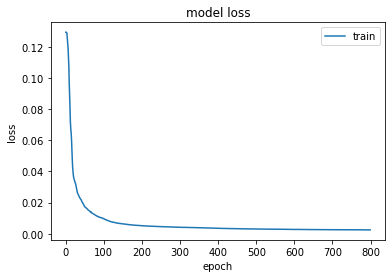

In [16]:
plt.plot(loss)
#plt.plot(tr_logs.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [ ]:
#vae.save('/Users/mezaga93/Desktop/vae_model.h5')

In [ ]:
#vae.load_weights('/Users/mezaga93/guitar_VAE-1/checkpoints')
#acc= vae.evaluate(Xw, Xw)
#print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

In [17]:
##get the latent space mean, sigma, z
latent = vae_encoder.predict(Xw)

2022-05-31 21:52:20.718203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


281/281 [==============================] - 21s 73ms/step


In [18]:
print(latent[0].shape)

(8970, 128)


In [19]:
y_hat = vae.predict(Xw)

2022-05-31 21:52:47.794367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


281/281 [==============================] - 63s 223ms/step


In [21]:
import IPython.display
import numpy as np
import json

def Audio(audio: np.ndarray, sr: int):
    """
    Use instead of IPython.display.Audio as a workaround for VS Code.
    `audio` is an array with shape (channels, samples) or just (samples,) for mono.
    """

    if np.ndim(audio) == 1:
        channels = [audio.tolist()]
    else:
        channels = audio.tolist()

    return IPython.display.HTML("""
        <script>
            if (!window.audioContext) {
                window.audioContext = new AudioContext();
                window.playAudio = function(audioChannels, sr) {
                    const buffer = audioContext.createBuffer(audioChannels.length, audioChannels[0].length, sr);
                    for (let [channel, data] of audioChannels.entries()) {
                        buffer.copyToChannel(Float32Array.from(data), channel);
                    }
            
                    const source = audioContext.createBufferSource();
                    source.buffer = buffer;
                    source.connect(audioContext.destination);
                    source.start();
                }
            }
        </script>
        <button onclick="playAudio(%s, %s)">Play</button>
    """ % (json.dumps(channels), sr))

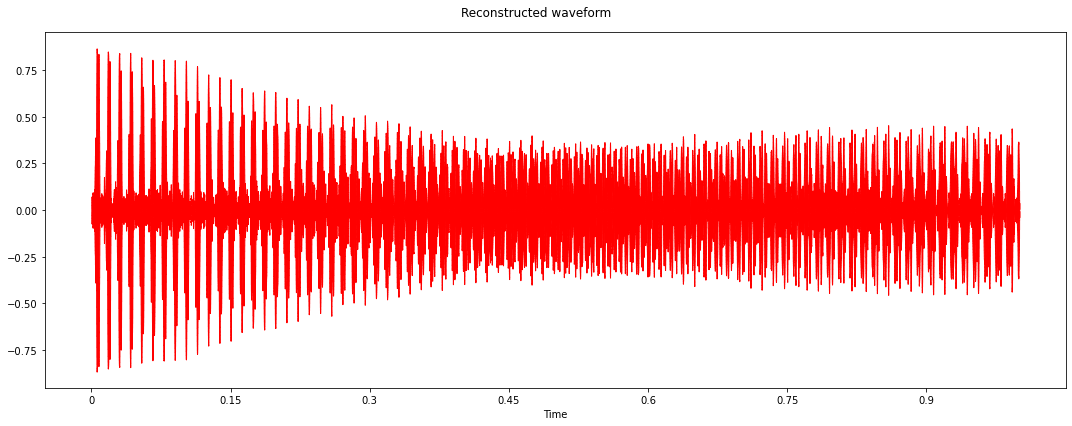

In [22]:
import matplotlib.pyplot as plt
import librosa.display
 
plt.figure(figsize=(15, 6)).suptitle("Reconstructed waveform")
librosa.display.waveshow(y_hat[115].flatten(),sr= sr16k, color='r')
plt.tight_layout()
plt.show()

In [23]:
#print(sonidos)
Audio(y_hat[115].flatten(), sr16k)

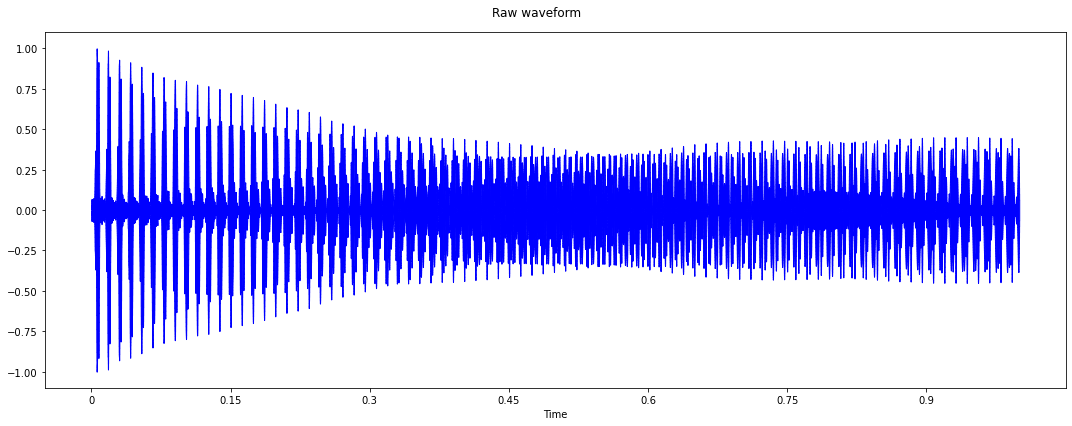

In [24]:

plt.figure(figsize=(15, 6)).suptitle("Raw waveform")
librosa.display.waveshow(Xw[115].flatten(),sr= sr16k, color='b')
plt.tight_layout()
plt.show()

In [25]:
Audio(Xw[115].flatten(),sr16k)

/var/folders/qs/3zzqvkk15cx77yqry0yt8x8h0000gn/T/ipykernel_12494/1655717427.py:6: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.display.waveshow(y_hat[x].flatten(),sr16k,color='r')


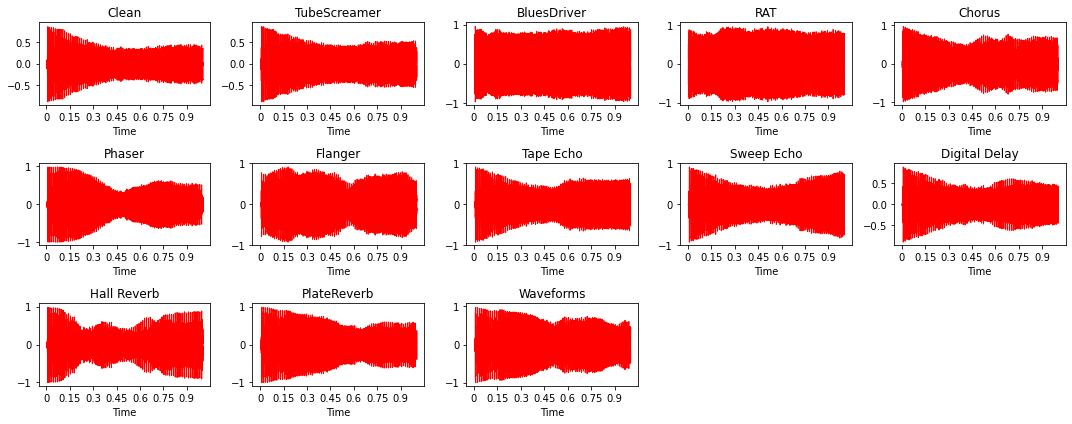

In [44]:
####visualización de los audios antes de normalizar
plt.figure(figsize=(15, 6))
sonidos = [i for i in range(115,len(Xw),690)]
for i, x in enumerate(sonidos):
    plt.subplot(3, 5, i+ 1).set_title(fx[i])
    librosa.display.waveshow(y_hat[x].flatten(),sr16k,color='r')
plt.tight_layout()
plt.title("Waveforms")
plt.show()

/var/folders/qs/3zzqvkk15cx77yqry0yt8x8h0000gn/T/ipykernel_12494/1874851277.py:5: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.display.waveshow(Xw[x].flatten(),sr16k, color='b')


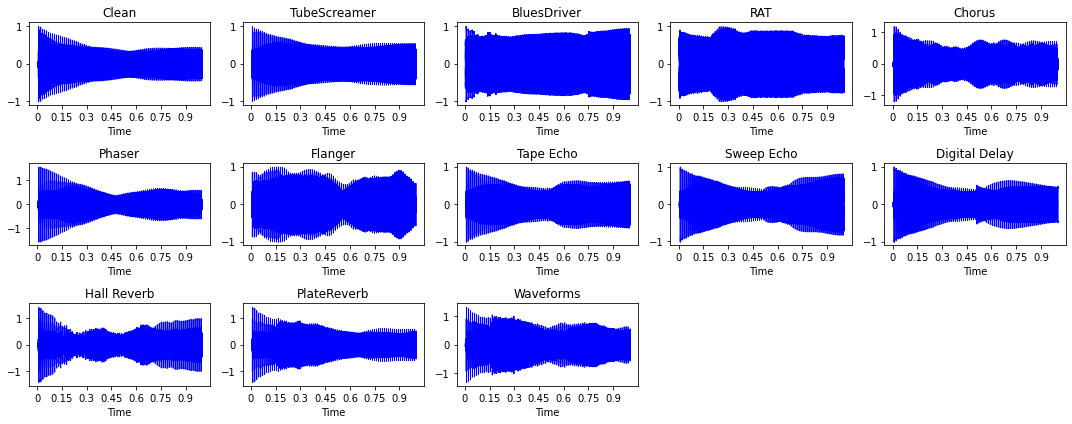

In [45]:
plt.figure(figsize=(15, 6))
sonidos = [i for i in range(115,len(Xw),690)]
for i, x in enumerate(sonidos):
    plt.subplot(3, 5, i+ 1).set_title(fx[i])
    librosa.display.waveshow(Xw[x].flatten(),sr16k, color='b')
plt.tight_layout()
plt.title("Waveforms")
plt.show()

In [29]:
from scipy.io.wavfile import write
for i in range(13):
    write("reconstruction_"+fx[i]+".wav", sr16k, y_hat[sonidos[i]])

In [ ]:
########################## sampling ###########################
print(latent[0][2][0])
print(latent[0][3][0])

created = (latent[0][2]) +(latent[0][2]- latent[0][3])
print(created)
#gen = np.linspace(-20,50,sr16k)
#print(gen)

In [30]:
import numpy as np
def latent_inter(audio_a, audio_b, step = 1):
  'step hace referencia al numero de audios entre las referencias'
  if step == 1:
    listas = np.linspace(audio_a, audio_b, step + 1, endpoint=False).flatten()
  else:
    listas = np.linspace(audio_a, audio_b, step + 1, endpoint=False)
  return listas[1:]

In [ ]:
#audiosgen = latent_inter(latent[0][0], latent[0][690], 2)

<class 'numpy.ndarray'>


In [43]:
primero = sonidos[0]
print(primero)
segundo = sonidos[2]
gen_audio = 10
gen_latent = latent_inter(latent[0][primero],latent[0][segundo],gen_audio)
print(gen_latent.shape)


115
(10, 128)


1/1 [==============================] - 0s 10ms/step


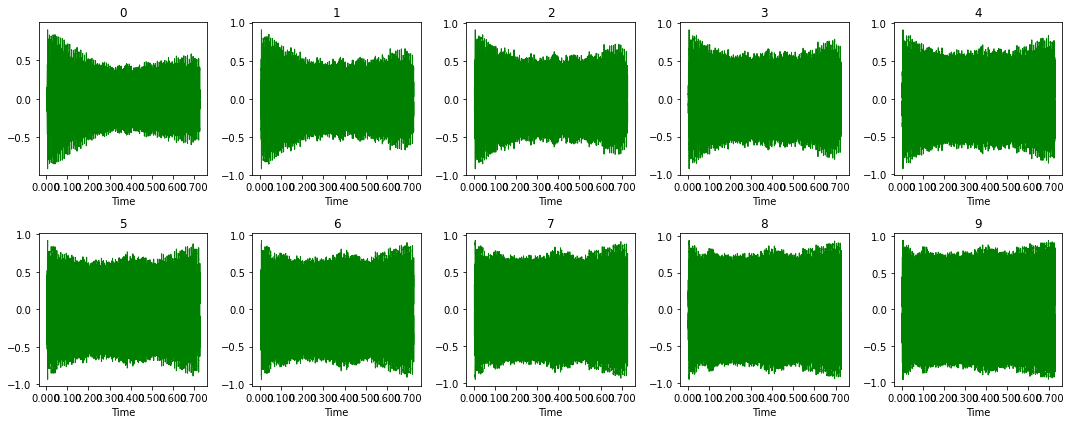

In [41]:
gen_latent = vae_decoder.predict(latent_inter(latent[0][primero],latent[0][segundo],gen_audio))
v = [gen_latent[i].flatten() for i in range(gen_audio)]
plt.figure(figsize=(15, 6))#.suptitle("Gen waveform")
for i in range(gen_audio):
    plt.subplot(2, 5, i+ 1).set_title(i)
    librosa.display.waveshow(v[i], color='green')
plt.tight_layout()
#plt.title()
plt.show()


In [42]:
Audio(v[0],sr16k)

In [ ]:
from scipy.io.wavfile import write
for i in range(13):
    write("reconstruction_"+fx[i]+".wav", sr16k, y_hat[sonidos[i]])

In [ ]:
v_wave = np.mean(v, axis= 1)[...,np.newaxis]
v_max_wave = np.max(v, axis=1)[...,np.newaxis]

v = (v- v_wave)/v_max_wave

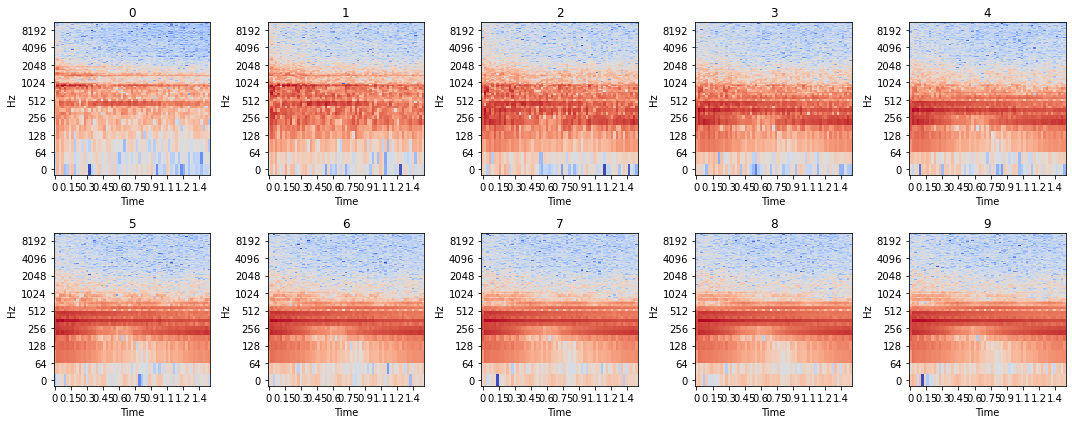

In [144]:
plt.figure(figsize=(15, 6))#.suptitle("STFT Data")
plt.title('stft')

for i in range(gen_audio):
    plt.subplot(2, 5, i + 1).set_title(i)
    stft = librosa.stft(v[i], n_fft=512, hop_length= (512-1)//2)
    stft = librosa.amplitude_to_db(np.abs(stft))
    librosa.display.specshow(stft, y_axis='log', x_axis='time')
plt.tight_layout()

plt.show()

In [189]:
def euclidean_distance(array1,array2):
    dist = np.linalg.norm(array1 - array2)
    return dist

In [190]:
def latent_sonidos_near(k, matriz, n):
    lista = []
    for j,array in enumerate(matriz):
        a = euclidean_distance(k, array)
        lista.append(a)
    idx = np.argpartition(lista, n)
    result = [matriz[i] for i in idx[:n]]
    result = np.array(result)
    return result

In [191]:
eucledean_near = latent_sonidos_near(latent[0][0], latent[0], 5)
#print(latent[0][0][:10])
#print(a[0][:10])
#print(euclidean_distance(latent[0][0], a[0]))
#print(a[1][:10])
#print(euclidean_distance(latent[0][0], a[1]))
#print(euclidean_distance(latent[0][0], a[2]))
#eucledean_near = np.array(eucledean_near)
print(eucledean_near.shape)

(5, 128)


1/1 [==============================] - 0s 8ms/step


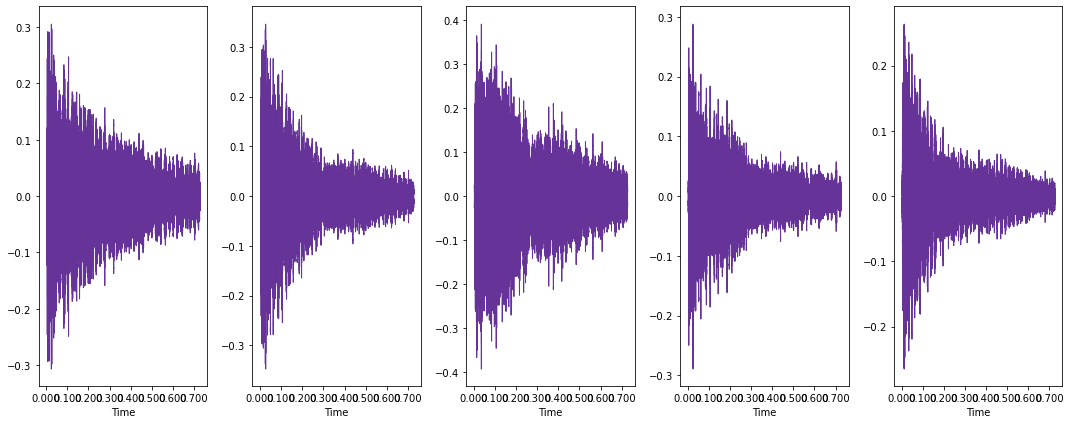

In [214]:
gen_latent = vae_decoder.predict(eucledean_near)
v = [gen_latent[i].flatten() for i in range(5)]
plt.figure(figsize=(15, 6))#.suptitle("Gen waveform")
for i in range(5):
    plt.subplot(1, 5, i+ 1)#.set_title(i)
    librosa.display.waveshow(v[i], color='rebeccapurple')
plt.tight_layout()
#plt.title()
plt.show()

In [206]:
Audio(v[0],sr16k)